In [1]:
import os
import shutil
import pandas as pd
import holidays
from time import time
from datetime import date, datetime, timezone
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

In [2]:
top_down_path = os.getcwd()
os.chdir("../Data")
data_path = os.getcwd()
os.chdir(top_down_path)

# Aggregated demand data

## BDEW (calculated from ENTSO-G, corrected with destatis)

In [52]:
bdew = pd.read_csv(os.path.join(data_path, "bdew.csv"), index_col =0)
bdew.index = pd.to_datetime(bdew.index, utc = True) - pd.Timedelta('6h')
bdew = (bdew / (10**9)).rename(columns={"Verbrauch":"bdew [TWh]"})

## Trading Hub Europe: SLPs & RLMs

In [29]:
#read
the = pd.read_csv(os.path.join(data_path, "THE.csv"), sep=";")

#to datetime 
the.index = the["Gastag"].apply(lambda x: pd.to_datetime(str(x), format='%d.%m.%Y', utc=True))# errors='coerce',

#to numeric
the = the.iloc[:, 1:-1].fillna("0")
the = the.iloc[::-1] 
the = the.apply(lambda x: x.apply(lambda y: float(y.replace(".", ""))))

#to TWh
the = the / (10**9)

In [30]:
#distinguish between industrial and households+ consumption 
the_slp = the.loc[:,"SLPsyn H-Gas": "SLPana L-Gas"].sum(1).to_frame().rename(columns={0:"slp_the [TWh]"})
the_rlm = the.loc[:, "RLMmT H-Gas":"RLMoT L-Gas"].sum(1).to_frame().rename(columns={0:"rlm_the [TWh]"})
the_sum = (the_slp.iloc[:,0] + the_rlm.iloc[:,0]).to_frame().rename(columns={0:"slp + rlm [TWh]"})

## THE-BDEW comparison

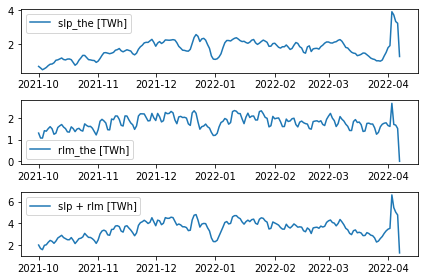

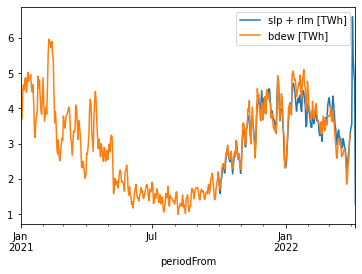

In [74]:
fig, axs = plt.subplots(3)

df_list = [the_slp, the_rlm, the_sum]

for i, df in enumerate(df_list):
    axs[i].plot(df.index, df.iloc[:,0], label=df.columns[0])
    axs[i].legend()
    plt.tight_layout()

ax = the_sum.plot()
bdew.plot(ax=ax)
ax.set_xticks(ax.get_xticks()[::2])

plt.show()

##Über & danach Unterschätzung 

In [32]:
the_sum.iloc[0].name

Timestamp('2021-10-01 00:00:00+0000', tz='UTC')

In [33]:
common_date = the_sum.iloc[0].name
bdew_sum = bdew.loc[bdew.index>common_date].sum()[0]
the_sum_sum = the_sum.loc[the_sum.index>common_date].sum()[0]

print("Energy consumption since: {}".format(common_date.strftime("%Y-%m-%d")) + "\n" +
      "the [TWh]: "+ str(the_sum_sum) + "\n" +
      "bdew [TWh]: "+ str(bdew_sum) + "\n" +
      "delta [%]: " + str(100 * (the_sum_sum - bdew_sum )/ 
                    the_sum_sum)
                        ) 

Energy consumption since: 2021-10-01
the [TWh]: 660.629381757
bdew [TWh]: 638.89480255
delta [%]: 3.289980707366521


# Proxies / control variables / disaggregated demand
## Estimated SLP

In [36]:
estimated = pd.read_csv(os.path.join(data_path, "SLPs.csv"), index_col="time")
estimated.index = pd.to_datetime(estimated.index, utc = True)

Gas consumption accoriding to AGEB in decentralized units will be mostly small CHP and hence temperature dependent. THis increases overall temperature-dependent gas consumption from 384 to 396 TWh.

In [37]:
estimated['aggregated(incl_small_chp)'] = estimated['aggregated(incl_dist_heat)'] * 396 / 384

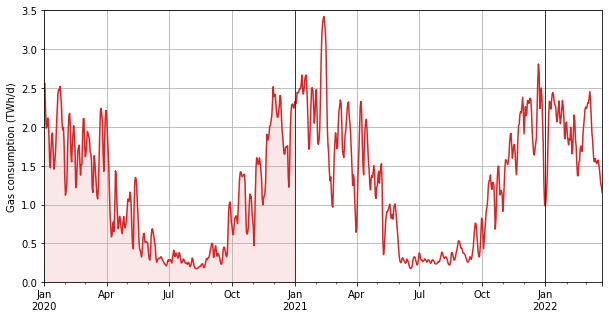

In [38]:
estimated['aggregated(incl_small_chp)'].plot(color='tab:red', figsize=(10,5))
plt.grid()
estimated2020 = estimated[estimated.index.year==2020]['aggregated(incl_small_chp)']
plt.fill_between(estimated2020.index, 0, estimated2020, color='tab:red', alpha=0.1)
plt.xlabel('')
plt.ylabel('Gas consumption (TWh/d)')
plt.ylim(0, 3.5)
plt.axvline('2021-01-01', color='black', linewidth=0.7)
plt.axvline('2022-01-01', color='black', linewidth=0.7)

## Gas for electricity generation

In [68]:
power = pd.read_csv(os.path.join(data_path, "entsoe_2020_gas.csv"), index_col=0)
power.index = pd.to_datetime(power.index, utc = True) #+ pd.Timedelta('1h')

In [72]:
power.index.tz_convert('Europe/Berlin').tz_localize(None)

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2022-03-28', '2022-03-29', '2022-03-30', '2022-03-31',
               '2022-04-01', '2022-04-02', '2022-04-03', '2022-04-04',
               '2022-04-05', '2022-04-06'],
              dtype='datetime64[ns]', length=827, freq=None)

In [40]:
power_gas[power_gas.index.year==2020].sum()

scaled_to_AGEBL_2020 [TWh_gas/day]    202.867559
dtype: float64

In [41]:
electricity_from_gas = pd.read_csv(os.path.join(data_path, "electricity_from_gas.csv"), 
                                   index_col=0, parse_dates=True).iloc[:, 0]

In [187]:
electricity_from_gas[electricity_from_gas.index.year==2020].sum() / 1000000

59.12599025

Scaled to 185 TWh in 2020, which is the sum of public power plants, public CHP, and industrial power plants (probably also mostly CHP):

In [259]:
gas_to_electricity = electricity_from_gas * 189 / (
    electricity_from_gas[electricity_from_gas.index.year==2020].sum()
)

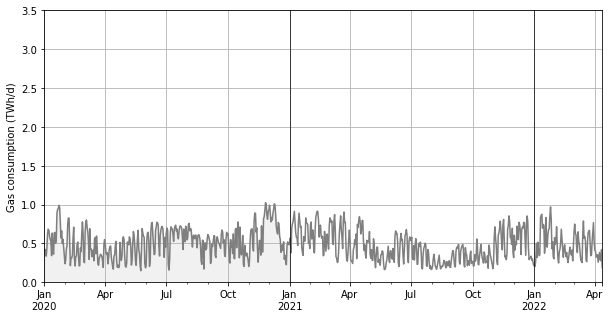

In [260]:
gas_to_electricity.plot(color='tab:grey', figsize=(10,5))
plt.grid()
power2020 = gas_to_electricity[gas_to_electricity.index.year==2020]
plt.fill_between(power2020.index, 0, power2020, color='tab:grey', alpha=0.1)
plt.xlabel('')
plt.ylabel('Gas consumption (TWh/d)')
plt.ylim(0, 3.5)
plt.axvline('2021-01-01', color='black', linewidth=0.7)
plt.axvline('2022-01-01', color='black', linewidth=0.7)

In [191]:
# power_gas.plot(figsize=(10,5))

## Fuelswitch / VRE 
## Peaks nach unten? 
## CO2 Preis

## Gas prices

In [192]:
gas_prices = pd.read_excel(os.path.join(data_path, "gas_prices_TTF.xlsx"), index_col=0)
gas_prices = gas_prices["Erdgas Spot TTF (lhs)"].to_frame().rename(columns={
    "Erdgas Spot TTF (lhs)":"gas_price [$/lhs]"}).dropna()
gas_prices.index = pd.to_datetime(gas_prices.index, utc = True).date

<AxesSubplot:>

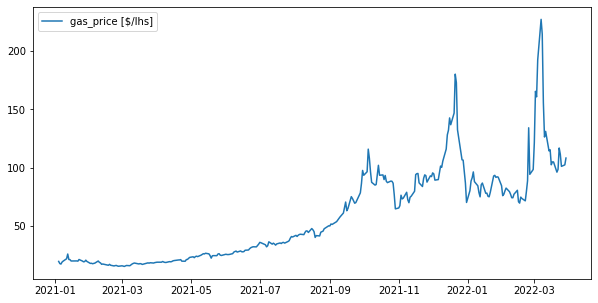

In [193]:
gas_prices.plot(figsize=(10,5))

# Analysis & plotting

## Align indexes
All calculations and plots are done for the same period: 01.10.2021-25.03.2022

In [227]:
first = bdew.iloc[0].name
last = estimated.iloc[-1].name

def unify_index(df):
    try:
        return df.loc[(df.index >= first) & (df.index <= last)]
    except:
        return df.loc[(df.index.date >= first) & (df.index.date <= last)]

In [239]:
estimated_new = unify_index(estimated)
the_slp_new = unify_index(the_slp)
the_rlm_new = unify_index(the_rlm)
the_sum_new = unify_index(the_sum)
bdew_new = unify_index(bdew)
gas_to_electricity = unify_index(gas_to_electricity)
gas_prices_new = unify_index(gas_prices)


#check if reindexing goes without problems:
#estimated_new = estimated_new.reindex(index=the_sum_new.index)

C:\Users\olive\miniconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
C:\Users\olive\AppData\Local\Temp\ipykernel_8240\965047421.py:8: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return df.loc[(df.index.date >= first) & (df.index.date <= last)]


# Subtract gas for electricity generation

### Substact gas for electricity generation 

In [196]:
#bdew_res = bdew_new.subtract(power_gas_new.iloc[:, 0], axis = 0).rename(columns = {
#    "bdew [TWh]": "bdew_res"})

In [197]:
#the_rlm_res = the_rlm_new.subtract(power_gas_new.iloc[:, 0], axis = 0).rename(columns = {
#    "rlm_the [TWh]": "rlm_the_res"})
#the_sum_res = the_sum_new.subtract(power_gas_new.iloc[:, 0], axis = 0).rename(columns = {
#    "slp + rlm [TWh]": "slp_sum_res"})

## THE vs. our estimates

In [198]:
y1=estimated_new["aggregated(no_dist_heat)"].to_frame("estimated_slp")
y2=the_slp_new
y3 = the_rlm

### Weekly analyis: Russian invasion: 24.02. (Thu), Fasching: 28.02.-02.03. (Mon-Wed)

In [199]:
x = y3.loc[y3.index > pd.to_datetime("2022-02-23", utc = True).date()].index
y = (y3.iloc[:,0] - 0.33*y1.iloc[:,0]).loc[y3.index > pd.to_datetime("2022-02-23", utc = True).date()]

plt.plot(x, y) 

plt.ylim(0,)
plt.title("RLM-0.33SLP")
plt.xticks(ticks =x[:-10:10])

plt.show()

## residual vs. ohne-residual

TypeError: Cannot join tz-naive with tz-aware DatetimeIndex

In [ ]:
ax = (y3.iloc[:,0] - 0.33*y1.iloc[:,0]).to_frame().rename(columns={0:"RLM minus SLP "}).plot()
ax.set_ylim(0,2.5)
y3.plot(
    ax=ax, title = "RLM; RLM minus temperature-dependant SLP", figsize=(10,5))
plt.show()

In [ ]:
ax = y2.plot()
y1.plot(ax=ax, figsize=(10,5))

plt.show()

## THE vs. BDEW

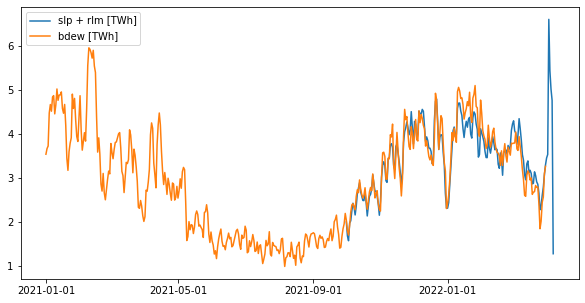

In [200]:
ax = the_sum.plot()
bdew.plot(ax=ax, figsize = (10,5))
ax.set_xticks(ax.get_xticks()[::2])

plt.show()

In [201]:
bdew_sum = bdew_new.sum()[0]
the_sum_sum = the_sum_new.sum()[0]

print("Energy consumption between: {} and {}".format(first.strftime("%Y-%m-%d"), 
                                                    last.strftime("%Y-%m-%d")) + "\n" +
      "the [TWh]: "+ str(the_sum_sum) + "\n" +
      "bdew [TWh]: "+ str(bdew_sum) + "\n" +
      "delta [%]: " + str(100 * (the_sum_sum - bdew_sum )/ 
                    the_sum_sum)
                        ) 

Energy consumption between: 2021-01-01 and 2022-03-25
the [TWh]: 616.084159215
bdew [TWh]: 1324.7419253839998
delta [%]: -115.02613004560203


# Export

In [232]:
gas_to_electricity.index

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2022-03-16', '2022-03-17', '2022-03-18', '2022-03-19',
               '2022-03-20', '2022-03-21', '2022-03-22', '2022-03-23',
               '2022-03-24', '2022-03-25'],
              dtype='datetime64[ns]', length=449, freq=None)

In [240]:
df_all = pd.concat(
    [estimated_new[["aggregated(no_dist_heat)", "dist_heat", "aggregated(incl_small_chp)"]], 
     the_slp_new, the_rlm_new, #the_rlm_res, 
     bdew_new, #bdew_res, 
     gas_to_electricity, 
     gas_prices_new], 
    axis = 1
)

C:\Users\olive\miniconda3\lib\site-packages\pandas\core\dtypes\missing.py:505: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return lib.array_equivalent_object(


In [241]:
df_all#.to_csv(os.path.join(data_path, "preprocessed.csv"))

,aggregated(no_dist_heat),dist_heat,aggregated(incl_small_chp),slp_the [TWh],rlm_the [TWh],bdew [TWh],electricity_from_gas,gas_price [$/lhs]
2021-01-01,2.146070,0.110337,2.326920,NaN,NaN,3.544281,0.522071,NaN
2021-01-02,2.120128,0.109003,2.298791,NaN,NaN,3.672925,0.570382,NaN
2021-01-03,2.156039,0.110849,2.337728,NaN,NaN,3.730913,0.378169,NaN
2021-01-04,2.255681,0.115972,2.445767,NaN,NaN,4.477985,0.686360,19.840
2021-01-05,2.250272,0.115694,2.439902,NaN,NaN,4.672453,0.749740,18.000
...,...,...,...,...,...,...,...,...
2022-03-21,1.340926,0.068942,1.453926,1.392374,1.752227,2.692656,0.501134,96.302
2022-03-22,1.248650,0.064197,1.353873,1.298474,1.763850,2.834050,0.635613,98.745
2022-03-23,1.164591,0.059876,1.262731,1.192761,1.722181,2.790061,0.656999,117.000
2022-03-24,1.132335,0.058217,1.227757,1.139399,1.723889,2.802156,0.667661,111.610


In [248]:
df = df_all

In [249]:
df['index']= df.index
df['time'] = range(len(df))
df['time'] = df['time'].apply(float)
df['year'] = df["index"].apply(lambda x: x.year)
df['month'] = df['index'].apply(lambda x: x.month)

In [250]:
df['weekday'] = df['index'].apply(lambda x: x.strftime('%A'))
df['weekday_num'] = df['index'].apply(lambda x: x.weekday())
df['monday'] = df['weekday'].apply(lambda x: int(x=="Monday"))
df['friday'] = df['weekday'].apply(lambda x: int(x=="Friday"))
df['weekend'] = df['weekday'].apply(lambda x: int(x in ["Saturday", "Sunday"]))

In [251]:
df['christmas_period'] = df['index'].apply(
    lambda x: int((x.month==12)&(x.day in range(24,32)))
)

country_holidays = holidays.CountryHoliday('DE', prov='BY')
df['holiday'] = df['index'].apply(lambda x: int(x in country_holidays))
df['bridgeday'] = ((
    (df['holiday'].shift(24) + df['holiday'].shift(-24)) * 
    (df['weekend'].shift(24) + df['weekend'].shift(-24))
) > 0).apply(int)

In [252]:
df

,aggregated(no_dist_heat),dist_heat,aggregated(incl_small_chp),slp_the [TWh],rlm_the [TWh],bdew [TWh],electricity_from_gas,gas_price [$/lhs],index,time,year,month,weekday,weekday_num,monday,friday,weekend,christmas_period,holiday,bridgeday
2021-01-01,2.146070,0.110337,2.326920,NaN,NaN,3.544281,0.522071,NaN,2021-01-01,0.0,2021,1,Friday,4,0,1,0,0,1,0
2021-01-02,2.120128,0.109003,2.298791,NaN,NaN,3.672925,0.570382,NaN,2021-01-02,1.0,2021,1,Saturday,5,0,0,1,0,0,0
2021-01-03,2.156039,0.110849,2.337728,NaN,NaN,3.730913,0.378169,NaN,2021-01-03,2.0,2021,1,Sunday,6,0,0,1,0,0,0
2021-01-04,2.255681,0.115972,2.445767,NaN,NaN,4.477985,0.686360,19.840,2021-01-04,3.0,2021,1,Monday,0,1,0,0,0,0,0
2021-01-05,2.250272,0.115694,2.439902,NaN,NaN,4.672453,0.749740,18.000,2021-01-05,4.0,2021,1,Tuesday,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-21,1.340926,0.068942,1.453926,1.392374,1.752227,2.692656,0.501134,96.302,2022-03-21,444.0,2022,3,Monday,0,1,0,0,0,0,0
2022-03-22,1.248650,0.064197,1.353873,1.298474,1.763850,2.834050,0.635613,98.745,2022-03-22,445.0,2022,3,Tuesday,1,0,0,0,0,0,0
2022-03-23,1.164591,0.059876,1.262731,1.192761,1.722181,2.790061,0.656999,117.000,2022-03-23,446.0,2022,3,Wednesday,2,0,0,0,0,0,0
2022-03-24,1.132335,0.058217,1.227757,1.139399,1.723889,2.802156,0.667661,111.610,2022-03-24,447.0,2022,3,Thursday,3,0,0,0,0,0,0


In [253]:
df.to_csv(os.path.join(data_path, "preprocessed.csv"))

df['time'] = range(len(df))
df['time'] = df['time'].apply(float)
df['year'] = df['cet_cest_timestamp'].apply(lambda x: x[:4])
df['month'] = df['cet_cest_timestamp'].apply(lambda x: x[5:7])

df['weekday'] = df['cet_cest_timestamp'].apply(lambda x: pd.Timestamp(x).day_name())
df['weekday_num'] = df['cet_cest_timestamp'].apply(lambda x: pd.Timestamp(x).weekday())
df['monday'] = df['weekday'].apply(lambda x: int(x=="Monday"))
df['friday'] = df['weekday'].apply(lambda x: int(x=="Friday"))
df['weekend'] = df['weekday'].apply(lambda x: int(x in ["Saturday", "Sunday"]))

df['christmas_period'] = df['cet_cest_timestamp'].apply(
    lambda x: int((pd.Timestamp(x).month==12)&(pd.Timestamp(x).day in range(24,32)))
)

country_holidays = holidays.CountryHoliday('DE', prov='BY')
df['holiday'] = df['cet_cest_timestamp'].apply(lambda x: int(pd.Timestamp(x) in country_holidays))
df['bridgeday'] = ((
    (df['holiday'].shift(24) + df['holiday'].shift(-24)) * 
    (df['weekend'].shift(24) + df['weekend'].shift(-24))
) > 0).apply(int)